In [329]:
import data_loader
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tqdm import tqdm
import numpy as np
congress = "house"

In [330]:
isHouse = congress == "house"
arr, reps, bills = data_loader.house_records() if isHouse else data_loader.senate_records()

Unable to read 2017_711.xml
Unable to read 2011_2.xml
Unable to read 2015_581.xml
Unable to read 2013_2.xml
Unable to read 2019_2.xml
Unable to read 2017_2.xml
Unable to read 2015_2.xml


In [331]:
print(bills[0])
print(arr.shape)

{'session': '1st', 'rollcall-num': '261', 'action-date': '17-May-2017', 'majority': 'R', 'vote-question': 'Table Appeal of the Ruling of the Chair', 'vote-result': 'Passed', 'congress': '115', 'vote-desc': None, 'legis-num': 'MOTION', 'vote-type': 'YEA-AND-NAY', 'action-time': '6:21 PM'}
(829, 5431)


In [332]:
def getBillKey(bill):
    if isHouse: return 10000*int(bill["congress"]) + 1000*int(bill["session"][0]) + int(bill["rollcall-num"])
    else: return 10000*int(bill["congress"]) + 1000*int(bill["session"]) + int(bill["vote_number"])
print(max([int(bill["congress"]) for bill in bills]))
print(max([int(bill["session"][0]) for bill in bills]))
if(isHouse): print(max([int(bill["rollcall-num"]) for bill in bills]))
else: print(max([int(bill["vote_number"]) for bill in bills]))

116
2
949


In [333]:
billkeys = [getBillKey(bill) for bill in bills]
indices = [i for i, _ in sorted(enumerate(billkeys), key=lambda x:x[1])]
bills = [bills[i] for i in indices]
arr = arr[:, indices]

Casten (IL) (D-IL)


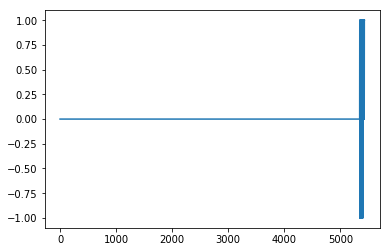

In [334]:
def infoRep(repid):
    print(reps[repid])
    plt.plot(arr[repid])
    plt.show()
    
infoRep(120)

In [335]:
# first bill of each session
firstbills = []
for bill in bills:
    if((isHouse and bill["rollcall-num"] == "1") or ((not isHouse) and bill["vote_number"] == "1")):
        firstbills.append(bill)
if isHouse: print([bill["action-date"] for bill in firstbills])
else: print([bill["vote_date"] for bill in firstbills])

['5-Jan-2011', '17-Jan-2012', '3-Jan-2013', '7-Jan-2014', '6-Jan-2015', '5-Jan-2016', '3-Jan-2017', '8-Jan-2018', '3-Jan-2019']


In [336]:
def filterReps(bill, inactiveThresh=None):
    """Find indices of representatives who have been around since bill.
    
    inactiveThresh specifies how many no-votes in a row indicate an inactive representative; default
    value is 20 or 50"""
    if not inactiveThresh: inactiveThresh = 50 if isHouse else 20
    billkey = getBillKey(bill)
    goodreps = []
    for i in range(len(reps)):
        streak = 0
        isgood = True
        for j in range(len(bills)):
            if(getBillKey(bills[j]) >= billkey): # if more recent than billkey
                if(arr[i][j] == 0): streak += 1
                else: streak = 0
                if(streak == inactiveThresh): isgood = False
        if(isgood): goodreps.append(i)
    return goodreps

def filterByParty(repindices, party):
    filteredreps = []
    for index in repindices:
        if reps[index][-5] == party:
            filteredreps.append(index)
    return filteredreps

def billsSince(bill):
    """Count how many bills have transpired since input bill."""
    count = 0
    for b in bills:
        if getBillKey(b) >= getBillKey(bill):
            count += 1
    return count

In [337]:
print(filterByParty(filterReps(firstbills[-2]), "D")) # test

[2, 5, 32, 39, 41, 46, 52, 57, 64, 65, 67, 75, 88, 89, 98, 99, 109, 113, 117, 121, 122, 129, 130, 132, 135, 137, 138, 141, 145, 152, 156, 157, 158, 162, 170, 174, 181, 186, 192, 193, 194, 196, 198, 201, 205, 208, 209, 215, 230, 233, 234, 239, 256, 264, 266, 270, 272, 287, 290, 295, 310, 336, 351, 355, 368, 371, 384, 386, 387, 391, 407, 410, 414, 415, 417, 418, 430, 433, 443, 445, 446, 449, 450, 464, 465, 467, 468, 474, 485, 492, 493, 502, 511, 514, 515, 521, 525, 526, 540, 543, 552, 553, 554, 561, 567, 575, 577, 579, 583, 587, 590, 593, 596, 602, 611, 615, 620, 629, 632, 662, 665, 667, 668, 679, 682, 683, 686, 688, 693, 695, 697, 699, 703, 710, 717, 719, 737, 739, 740, 743, 748, 749, 756, 758, 775, 776, 777, 778, 779, 790, 794, 801, 810, 819]


In [338]:
# how far back can we go while still having N active senators from then to today?
Ns = []
found = False
for i in range(len(firstbills)):
    Ns.append(len(filterReps(firstbills[i])))
Bs = [billsSince(bill) for bill in firstbills]

[[0, 5431], [128, 4483], [178, 3824], [190, 3184], [226, 2620], [234, 1917], [286, 1295], [304, 586], [431, 86]]


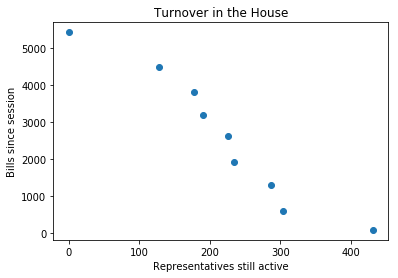

In [339]:
print([[Ns[i], Bs[i]] for i in range(len(Ns))])
plt.scatter(Ns, Bs)
plt.xlabel("Representatives still active")
plt.ylabel("Bills since session")
congresstitle = "House" if isHouse else "Senate"
plt.title("Turnover in the "+congresstitle)
plt.show()

In [340]:
# inspect above graph and set index
index = 8
print([[Ns[i], Bs[i]] for i in range(len(Ns))][index])
print(firstbills[index])

[431, 86]
{'session': '1st', 'rollcall-num': '1', 'legis-num': 'QUORUM', 'vote-result': 'Passed', 'majority': 'D', 'action-time': '12:39 PM', 'vote-desc': None, 'vote-type': 'QUORUM', 'vote-question': 'Call by States', 'action-date': '3-Jan-2019', 'congress': '116'}


In [341]:
if not isHouse: # senate
    choice = 8
    arrD = arr[filterByParty(filterReps(firstbills[choice]), "D"), :]
    arrD = arrD[:, -billsSince(firstbills[choice]):]
    arrR = arr[filterByParty(filterReps(firstbills[choice]), "R"), :]
    arrR = arrR[:, -billsSince(firstbills[choice]):]
    arrA = arr[filterReps(firstbills[choice]), :]
    arrA = arrA[:, -billsSince(firstbills[choice]):]
    np.save("senate_votes_d", arrD)
    np.save("senate_votes_r", arrR)
    np.save("senate_votes", arrA)
if isHouse:
    choice = 6
    arrD = arr[filterByParty(filterReps(firstbills[choice]), "D"), :]
    arrD = arrD[:, -billsSince(firstbills[choice]):]
    arrR = arr[filterByParty(filterReps(firstbills[choice]), "R"), :]
    arrR = arrR[:, -billsSince(firstbills[choice]):]
    arrA = arr[filterReps(firstbills[choice]), :]
    arrA = arrA[:, -billsSince(firstbills[choice]):]
    np.save("house_votes_d", arrD)
    np.save("house_votes_r", arrR)
    np.save("house_votes", arrA)